# Premature Optimization is the root of all evil

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numba import jit
import pstats
import heapq
import time
import cProfile
import pandas as pd

In [2]:
def getInversePerm(arr):
    # gets the inverse move for a certain move
    res = [0 for i in range(len(arr))]
    for i in range(len(arr)):
        res[arr[i]] = i
    return res

In [3]:
# File paths
puzzle_info_path = 'puzzle_info.csv'
puzzles_path = 'puzzles.csv'
sample_submission_path = 'submission.csv' # change name across board

# Loading the data
puzzle_info_df = pd.read_csv(puzzle_info_path)
puzzles_df = pd.read_csv(puzzles_path)
sample_submission_df = pd.read_csv(sample_submission_path)

# Displaying the first few rows of each dataframe
puzzles_df.describe()

,id,num_wildcards
count,398.000000,398.000000
mean,198.500000,1.809045
std,115.036951,10.047931
min,0.000000,0.000000
25%,99.250000,0.000000
50%,198.500000,0.000000
75%,297.750000,0.000000
max,397.000000,176.000000


In [4]:
puzzles_df.head()

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0


In [5]:
# Parsing the initial_state and solution_state columns
# Converting the semicolon-separated string values into lists of colors
puzzles_df['parsed_initial_state'] = puzzles_df['initial_state'].apply(lambda x: x.split(';'))
seen = {}

for i in range(len(puzzles_df['parsed_initial_state'])):
    for j in range(len(puzzles_df['parsed_initial_state'][i])):
        if puzzles_df['parsed_initial_state'][i][j] not in seen:
            seen[puzzles_df['parsed_initial_state'][i][j]] = len(seen)
        puzzles_df['parsed_initial_state'][i][j] = seen[puzzles_df['parsed_initial_state'][i][j]]

puzzles_df['parsed_solution_state'] = puzzles_df['solution_state'].apply(lambda x: x.split(';'))

for i in range(len(puzzles_df['parsed_solution_state'])):
    for j in range(len(puzzles_df['parsed_solution_state'][i])):
        puzzles_df['parsed_solution_state'][i][j] = seen[puzzles_df['parsed_solution_state'][i][j]]

# Displaying the modified dataframe with parsed states
puzzles_df[['id', 'puzzle_type', 'parsed_initial_state', 'parsed_solution_state']].head()

,id,puzzle_type,parsed_initial_state,parsed_solution_state
0,0,cube_2/2/2,"[0, 1, 0, 2, 1, 3, 2, 3, 4, 2, 4, 2, 0, 4, 0, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
1,1,cube_2/2/2,"[0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
2,2,cube_2/2/2,"[1, 5, 4, 4, 5, 2, 0, 0, 3, 3, 2, 5, 1, 3, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
3,3,cube_2/2/2,"[2, 4, 1, 4, 5, 0, 1, 0, 2, 2, 5, 2, 3, 0, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
4,4,cube_2/2/2,"[1, 0, 1, 0, 2, 1, 5, 3, 2, 4, 5, 0, 5, 0, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."


In [6]:
import json

# Converting the string representation of allowed_moves to dictionary
puzzle_info_df['allowed_moves'] = puzzle_info_df['allowed_moves'].apply(lambda x: json.loads(x.replace("'", '"')))

# Selecting an example puzzle type and displaying its allowed moves
example_puzzle_type = puzzle_info_df['puzzle_type'].iloc[0]
example_allowed_moves = puzzle_info_df[puzzle_info_df['puzzle_type'] == example_puzzle_type]['allowed_moves'].iloc[0]

example_puzzle_type

'cube_2/2/2'

In [7]:
# type : (np.array(move_perm_i), np.array(name_i))
puz_info = {}

for i in range(len(puzzle_info_df)):
    puz_info[puzzle_info_df['puzzle_type'][i]] = [[], []]
    for j in puzzle_info_df['allowed_moves'][i].keys():
        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(j)
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(puzzle_info_df['allowed_moves'][i][j]))

        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(str('-' + j)) # might be the opposite
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j])))

# Step 5: Develop search algorithm

In [8]:
@jit(nopython=True, parallel = True, fastmath = True)
def hash(perm):
    base = 9973
    modb = 1000000007
    modc = 1000000009

    B, C = 0, 0
    for i in perm:
        B = (B * base) % modb + i
        C = (C * base) % modc + i

    return (B, C)

def dist(a, b):
    return np.count_nonzero(a != b)

In [9]:
mx_mem = int(3e7)
mem_idx = 0

last_state = np.zeros(mx_mem, dtype=int)
last_move = np.zeros(mx_mem, dtype=int)

print(last_state)

[0 0 0 ... 0 0 0]


In [10]:
%%time

def a_star_search(idx):
    global mem_idx
    
    initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
    goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
    max_dist = puzzles_df['num_wildcards'][idx]
    move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

    n = len(initial_state)
    m = len(move_perm)
    
    pq = []
    heapq.heappush(pq, (0, mem_idx, initial_state))  # (priority, mem_idx, state)
    mem_idx += 1
    
    considered = set()
    considered.add(hash(initial_state))

    while mem_idx + m < mx_mem:
        cur_p, cur_idx, cur_state = heapq.heappop(pq) 
        cur_dist = dist(cur_state, goal_state)
        cur_p -= cur_dist 

        if cur_dist <= max_dist:
            return cur_idx
        
        for i in range(m):
            new_state = cur_state[move_perm[i]]
            cur_hash = hash(new_state)
            
            if cur_hash not in considered:
                considered.add(cur_hash)
                
                last_state[mem_idx] = cur_idx
                last_move[mem_idx] = i
                
                priority = cur_p + 1 + dist(new_state, goal_state)
                
                heapq.heappush(pq, (priority, mem_idx, new_state))
                mem_idx += 1
    return None


cProfile.run('a_star_search(2)')

/opt/homebrew/lib/python3.11/site-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/kd/99328vjn0zlc1kls78_rwvdh0000gn/T/ipykernel_39273/2450248532.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


         6559978 function calls (6538099 primitive calls) in 3.103 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   954925    0.228    0.000    0.228    0.000 2450248532.py:1(hash)
   856125    0.643    0.000    0.886    0.000 2450248532.py:14(dist)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:262(__subclasshook__)
        2    0.000    0.000    0.000    0.000 <frozen _collections_abc>:315(__subclasshook__)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:78(_check_methods)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:786(keys)
        2    0.000    0.000    0.000    0.000 <frozen _collections_abc>:790(items)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:812(__init__)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:815(__len__)
        5    0.000    0.000    0.000    0.000 <frozen _collections_abc

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


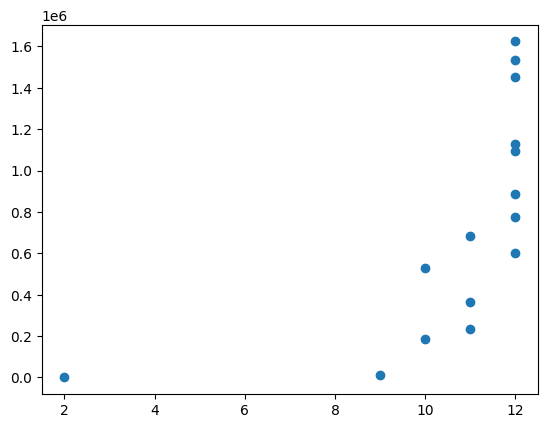

In [30]:
def dig_through_memory(idx):
    res = []
    while idx != 0:
        res.append(last_move[idx])
        idx = last_state[idx]

    res = list(reversed(res))
    return res

def solve(idx):
    global mem_idx
    
    mem_idx = 0
    
    move_name = np.array(puz_info[puzzles_df['puzzle_type'][idx]][1])

    res = a_star_search(idx)
    
    if res == None:
        print("NONE")
        return sample_submission_df['moves'][idx]
        
    res = dig_through_memory(res)
    for i in range(len(res)):
        res[i] = move_name[res[i]]

    return res

xs = []
ys = []

for i in range(15):
    xs.append(len(solve(i)))
    ys.append(mem_idx)
    print(i)

plt.scatter(xs, ys)

In [31]:
print(xs)

[2, 9, 12, 10, 12, 12, 12, 11, 12, 12, 10, 11, 12, 11, 12]


In [32]:
print(ys)

[24, 13135, 776548, 530593, 886187, 1536272, 600709, 366406, 1126437, 1094306, 185059, 684690, 1450214, 232174, 1623402]


# Step 6: Build submission format function

In [12]:
def format_solution_for_submission(puzzle_id, solution_moves):
    """
    Format the solution to a puzzle for submission.

    :param puzzle_id: The unique identifier of the puzzle.
    :param solution_moves: List of tuples representing the solution moves.
    :return: Formatted string suitable for submission.
    """
    formatted_moves = []
    for move in solution_moves:
        formatted_moves.append(move)

    # Joining the moves into a single string separated by periods
    return {'id': puzzle_id, 'moves': '.'.join(formatted_moves)}


# Step 7: Define solve function

In [13]:
from tqdm import tqdm

res_df = []

for i in tqdm(range(len(puzzles_df))):
    res = solve(i)
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        res = format_solution_for_submission(i, res)
    res_df.append(res)

  1%|▍                                          | 4/398 [00:04<07:08,  1.09s/it]


KeyboardInterrupt: 

In [ ]:
res_df = pd.DataFrame(res_df)
res_df

# Step 9: Save submission

In [ ]:
# Define the file path for the output CSV file
output_csv_path = 'submission.csv'

# Save the output DataFrame to a CSV file
res_df.to_csv(output_csv_path, index=False)

# Return the path of the saved file
output_csv_path